# SABR Calibration

**Approach:**
- Uses **closing prices** for mid and spot
- **Multi-start optimization** (20 initial guesses)
- Processes **all dates** in RTH or ETH folder
- One SABR output per day

**Reference:** `calibration (full).ipynb`

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import least_squares, brentq
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. SABR Model Implementation

Using Hagan's formula from `calibration (full).ipynb`

Beta is often fixed a priori. Used 0.7 based on some papers, 0.5 as well. No distinct differences in output. 


In [2]:
def SABR(F, K, T, alpha, beta, rho, nu):
    """Hagan's SABR implied volatility formula."""
    X = K
    # ATM case
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma


def sabrcalibration(x, strikes, vols, F, T, beta):
    """Objective function for SABR calibration."""
    err = 0.0
    for i, vol in enumerate(vols):
        try:
            model_vol = SABR(F, strikes[i], T, x[0], beta, x[1], x[2])
            if np.isnan(model_vol) or np.isinf(model_vol):
                err += 1e6
            else:
                err += (vol - model_vol)**2
        except:
            err += 1e6
    return err

print("✓ SABR model defined")

✓ SABR model defined


## 2. Black-Scholes Pricing & IV Calculation

In [3]:
def BlackScholesCall(S, K, r, sigma, T):
    """Black-Scholes call price."""
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesPut(S, K, r, sigma, T):
    """Black-Scholes put price."""
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


def impliedVolatility(S, K, r, price, T, payoff):
    """Calculate implied volatility using Brent's method."""
    try:
        if payoff.lower() == 'call':
            impliedVol = brentq(
                lambda x: price - BlackScholesCall(S, K, r, x, T),
                1e-6, 5.0
            )
        elif payoff.lower() == 'put':
            impliedVol = brentq(
                lambda x: price - BlackScholesPut(S, K, r, x, T),
                1e-6, 5.0
            )
        else:
            raise ValueError('Payoff type not recognized')
    except:
        impliedVol = np.nan

    return impliedVol

print("✓ Black-Scholes functions defined")

✓ Black-Scholes functions defined


## 3. Data Loading - Closing Prices

In [4]:
def load_closing_prices(date, expiry, session='RTH'):
    """Load closing bid/ask prices for a given date and expiry."""
    base_path = Path(session)

    # Load files
    call_bid = pd.read_csv(base_path / f'{date}_call_bid_{expiry}.csv', index_col=0)
    call_ask = pd.read_csv(base_path / f'{date}_call_ask_{expiry}.csv', index_col=0)
    put_bid = pd.read_csv(base_path / f'{date}_put_bid_{expiry}.csv', index_col=0)
    put_ask = pd.read_csv(base_path / f'{date}_put_ask_{expiry}.csv', index_col=0)
    assets = pd.read_csv(base_path / f'{date}_assets.csv')

    # Get closing prices (last row, -1 values are treated as NaN)
    call_bid_close = call_bid.iloc[-1].replace(-1.0, np.nan)
    call_ask_close = call_ask.iloc[-1].replace(-1.0, np.nan)
    put_bid_close = put_bid.iloc[-1].replace(-1.0, np.nan)
    put_ask_close = put_ask.iloc[-1].replace(-1.0, np.nan)

    # Calculate mids
    call_mid = (call_bid_close + call_ask_close) / 2
    put_mid = (put_bid_close + put_ask_close) / 2

    # Get strikes
    strikes = call_bid.columns.astype(float)

    # Get closing spot
    S = assets['SPX'].iloc[-1]

    return {
        'strikes': strikes,
        'call_mid': call_mid,
        'put_mid': put_mid,
        'spot': S
    }


def calculate_implied_vols(data, date, expiry, r=0.0014):
    """Calculate implied volatilities from mid prices."""
    # Time to maturity
    trade_date = pd.to_datetime(date)
    expiry_date = pd.to_datetime(expiry, format='%Y%m%d')
    T = (expiry_date - trade_date).days / 365.25

    S = data['spot']
    F = S * np.exp(r * T)

    # Calculate IVs
    results = []
    for strike in data['strikes']:
        strike_val = float(strike)
        strike_key = str(strike)  # Keep as string for indexing

        # Use puts for OTM puts, calls for OTM calls
        if strike_val <= S:
            # Use put
            mid_price = data['put_mid'][strike_key]
            if pd.notna(mid_price) and mid_price > 0:
                iv = impliedVolatility(S, strike_val, r, mid_price, T, 'put')
                if pd.notna(iv) and 0.01 < iv < 2.0:  # Sanity check
                    results.append({
                        'strike': strike_val,
                        'iv': iv,
                        'type': 'put'
                    })
        else:
            # Use call
            mid_price = data['call_mid'][strike_key]
            if pd.notna(mid_price) and mid_price > 0:
                iv = impliedVolatility(S, strike_val, r, mid_price, T, 'call')
                if pd.notna(iv) and 0.01 < iv < 2.0:  # Sanity check
                    results.append({
                        'strike': strike_val,
                        'iv': iv,
                        'type': 'call'
                    })

    df = pd.DataFrame(results)
    df['F'] = F
    df['T'] = T
    df['S'] = S

    return df

print("✓ Data loading functions defined")

✓ Data loading functions defined


## 4. Multi-Start SABR Calibration
Set up a grid of initial guesses. 
Run the SABR model based on the initial guesses. 
Select the SABR model params that has the lowest RMSE.

In [5]:
def calibrate_sabr_multistart(strikes, vols, F, T, beta=0.7, n_starts=20):
    """
    Calibrate SABR with multi-start optimization.

    Returns:
        Best parameters (alpha, rho, nu) and minimum error
    """

    # ATM volatility for scaling
    atm_idx = np.argmin(np.abs(strikes - F))
    atm_vol = vols[atm_idx]

    # Grid of initial guesses
    alpha_starts = np.linspace(0.1 * atm_vol, 2.0 * atm_vol, 5)
    rho_starts = np.linspace(-0.9, 0.5, 4)
    nu_starts = np.linspace(0.1, 3.0, 4)

    # Generate all combinations (limit to n_starts)
    starts = []
    for alpha in alpha_starts:
        for rho in rho_starts:
            for nu in nu_starts:
                starts.append([alpha, rho, nu])
                if len(starts) >= n_starts:
                    break
            if len(starts) >= n_starts:
                break
        if len(starts) >= n_starts:
            break

    best_result = None
    best_error = np.inf

    print(f"  Multi-start optimization with {len(starts)} initial guesses...")

    for i, x0 in enumerate(starts):
        try:
            # Bounds: alpha > 0, -1 < rho < 1, nu > 0
            bounds = ([1e-6, -0.999, 1e-6], [10.0, 0.999, 10.0])

            res = least_squares(
                lambda x: sabrcalibration(x, strikes, vols, F, T, beta),
                x0,
                bounds=bounds,
                method='trf',
                max_nfev=500,
                verbose=0
            )

            error = res.cost

            if error < best_error:
                best_error = error
                best_result = res.x

        except Exception as e:
            continue

    if best_result is None:
        raise ValueError("All optimization attempts failed!")

    return {
        'alpha': best_result[0],
        'beta': beta,
        'rho': best_result[1],
        'nu': best_result[2],
        'error': best_error,
        'rmse': np.sqrt(best_error / len(strikes))
    }

print("✓ Multi-start calibration defined")

✓ Multi-start calibration defined


## 5. Process All Dates in RTH Folder
- Note: 
  - beta is frequently pre-selecte 


In [6]:
def process_all_dates(session='RTH', beta=0.5):
    """Process all available dates in the specified session folder."""
    base_path = Path(session)

    # Find all unique dates
    files = list(base_path.glob('*_call_bid_*.csv'))
    date_expiry_pairs = []

    for file in files:
        parts = file.stem.split('_')
        date = parts[0]
        expiry = parts[3]
        date_expiry_pairs.append((date, expiry))

    date_expiry_pairs = sorted(set(date_expiry_pairs))

    print(f"Found {len(date_expiry_pairs)} date-expiry pairs in {session}")
    print("="*80)

    results = []

    for date, expiry in date_expiry_pairs:
        print(f"\nProcessing {date} → {expiry}")
        print("-"*80)

        try:
            # Load data
            data = load_closing_prices(date, expiry, session)
            print(f"  Spot: {data['spot']:.2f}")

            # Calculate IVs
            iv_df = calculate_implied_vols(data, date, expiry)
            print(f"  Valid IVs: {len(iv_df)}")

            if len(iv_df) < 10:
                print("  ⚠️  Too few valid IVs, skipping...")
                continue

            # Calibrate SABR
            sabr_params = calibrate_sabr_multistart(
                iv_df['strike'].values,
                iv_df['iv'].values,
                iv_df['F'].iloc[0],
                iv_df['T'].iloc[0],
                beta=beta,
                n_starts=20
            )

            print(f"  ✓ SABR: α={sabr_params['alpha']:.4f}, β={beta:.1f}, ρ={sabr_params['rho']:.4f}, ν={sabr_params['nu']:.4f}")
            print(f"  ✓ RMSE: {sabr_params['rmse']:.6f} ({sabr_params['rmse']*100:.4f}%)")

            # Store results
            results.append({
                'date': date,
                'expiry': expiry,
                'session': session,
                'spot': data['spot'],
                'forward': iv_df['F'].iloc[0],
                'T': iv_df['T'].iloc[0],
                'n_strikes': len(iv_df),
                'alpha': sabr_params['alpha'],
                'beta': beta,
                'rho': sabr_params['rho'],
                'nu': sabr_params['nu'],
                'rmse': sabr_params['rmse'],
                'iv_data': iv_df
            })

        except Exception as e:
            print(f"  ✗ Error: {e}")
            import traceback
            traceback.print_exc()
            continue

    return results

print("✓ Batch processing function defined")

✓ Batch processing function defined


## 6. Run Calibration on All RTH Dates

In [7]:
# Process RTH data
print("\n" + "="*80)
print("PROCESSING RTH (Regular Trading Hours)")
print("="*80)
rth_results = process_all_dates(session='RTH', beta=0.7)


PROCESSING RTH (Regular Trading Hours)
Found 8 date-expiry pairs in RTH

Processing 2025-04-01 → 20250416
--------------------------------------------------------------------------------
  Spot: 5633.07
  Valid IVs: 74
  Multi-start optimization with 20 initial guesses...
  ✓ SABR: α=2.5158, β=0.7, ρ=-0.6053, ν=3.6601
  ✓ RMSE: 0.000806 (0.0806%)

Processing 2025-04-02 → 20250416
--------------------------------------------------------------------------------
  Spot: 5670.97
  Valid IVs: 68
  Multi-start optimization with 20 initial guesses...
  ✓ SABR: α=2.3988, β=0.7, ρ=-0.5345, ν=3.8146
  ✓ RMSE: 0.003437 (0.3437%)

Processing 2025-04-03 → 20250416
--------------------------------------------------------------------------------
  Spot: 5396.52
  Valid IVs: 81
  Multi-start optimization with 20 initial guesses...
  ✓ SABR: α=3.4998, β=0.7, ρ=-0.5913, ν=4.2010
  ✓ RMSE: 0.001552 (0.1552%)

Processing 2025-04-04 → 20250416
--------------------------------------------------------------

## 7. Save Results Summary

In [8]:
# Create summary DataFrame
summary_df = pd.DataFrame([{
    'date': r['date'],
    'expiry': r['expiry'],
    'session': r['session'],
    'spot': r['spot'],
    'forward': r['forward'],
    'T': r['T'],
    'n_strikes': r['n_strikes'],
    'alpha': r['alpha'],
    'beta': r['beta'],
    'rho': r['rho'],
    'nu': r['nu'],
    'rmse': r['rmse']
} for r in rth_results])

# Save to CSV
summary_df.to_csv('sabr_calibration_results_RTH.csv', index=False)

print("\n" + "="*80)
print("Results saved to: sabr_calibration_results_RTH.csv")
print("="*80)
print(f"\nTotal successful calibrations: {len(summary_df)}")
print("\nSummary:")
display(summary_df)


Results saved to: sabr_calibration_results_RTH.csv

Total successful calibrations: 8

Summary:


,date,expiry,session,spot,forward,T,n_strikes,alpha,beta,rho,nu,rmse
0,2025-04-01,20250416,RTH,5633.07,5633.393882,0.041068,74,2.515835,0.7,-0.605281,3.660110,0.000806
1,2025-04-02,20250416,RTH,5670.97,5671.274323,0.038330,68,2.398776,0.7,-0.534495,3.814579,0.003437
2,2025-04-03,20250416,RTH,5396.52,5396.788909,0.035592,81,3.499763,0.7,-0.591286,4.200981,0.001552
3,2025-04-04,20250416,RTH,5074.08,5074.313392,0.032854,73,5.949912,0.7,-0.718079,4.461910,0.000833
4,2025-04-07,20250515,RTH,5062.25,5062.987389,0.104038,79,4.693968,0.7,-0.703389,1.827716,0.001941
5,2025-04-08,20250515,RTH,4982.77,4983.476710,0.101300,73,5.204045,0.7,-0.792890,2.291697,0.000357
6,2025-04-09,20250515,RTH,5456.90,5457.653037,0.098563,81,3.373555,0.7,-0.715634,2.660686,0.000192
7,2025-04-10,20250515,RTH,5268.05,5268.756781,0.095825,73,4.368527,0.7,-0.796634,2.229264,0.000917


## 8. Visualization - Plot SABR Fits

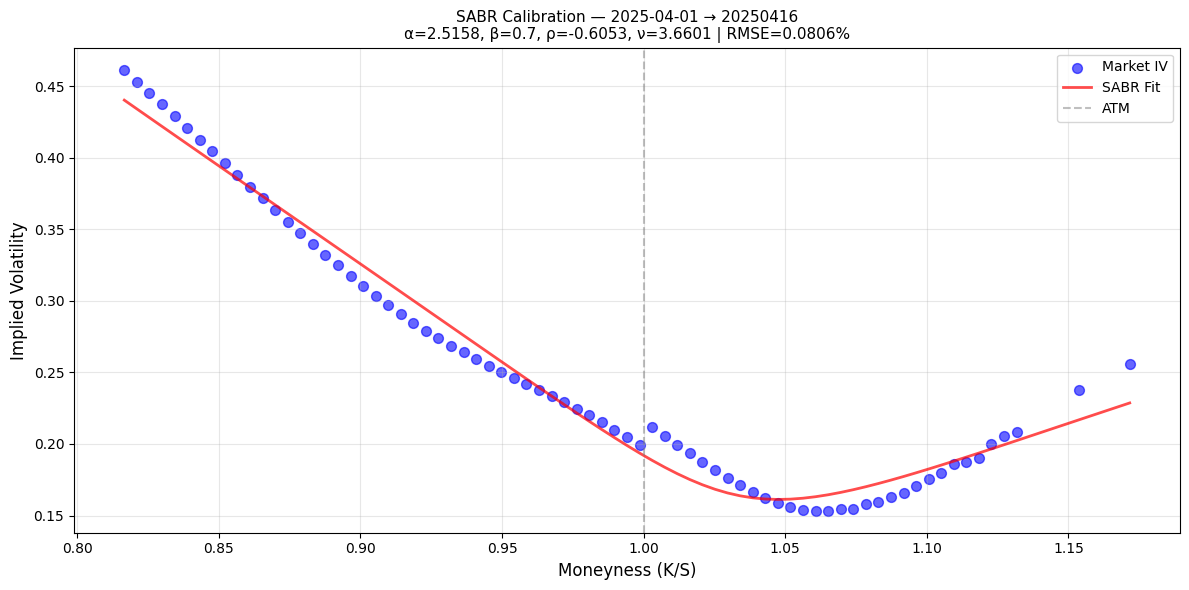

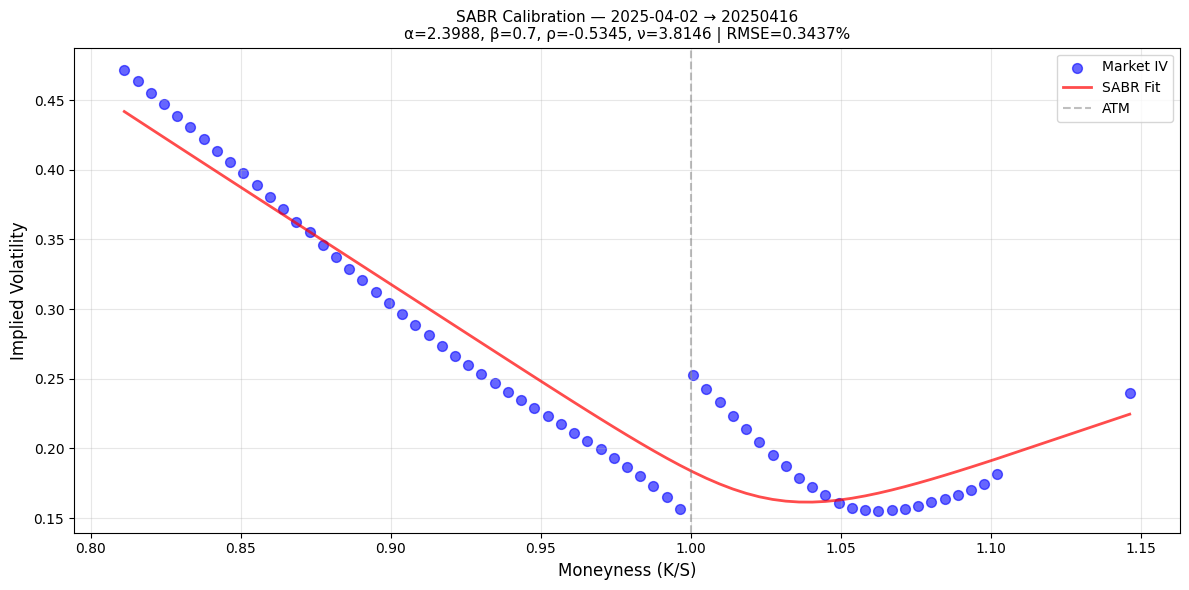

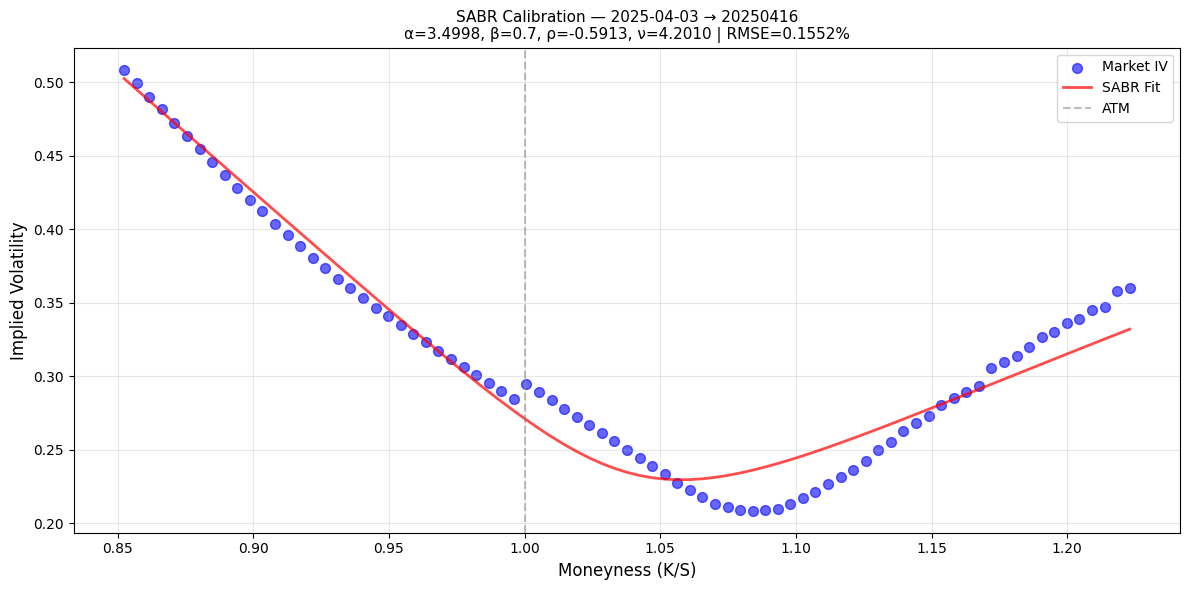

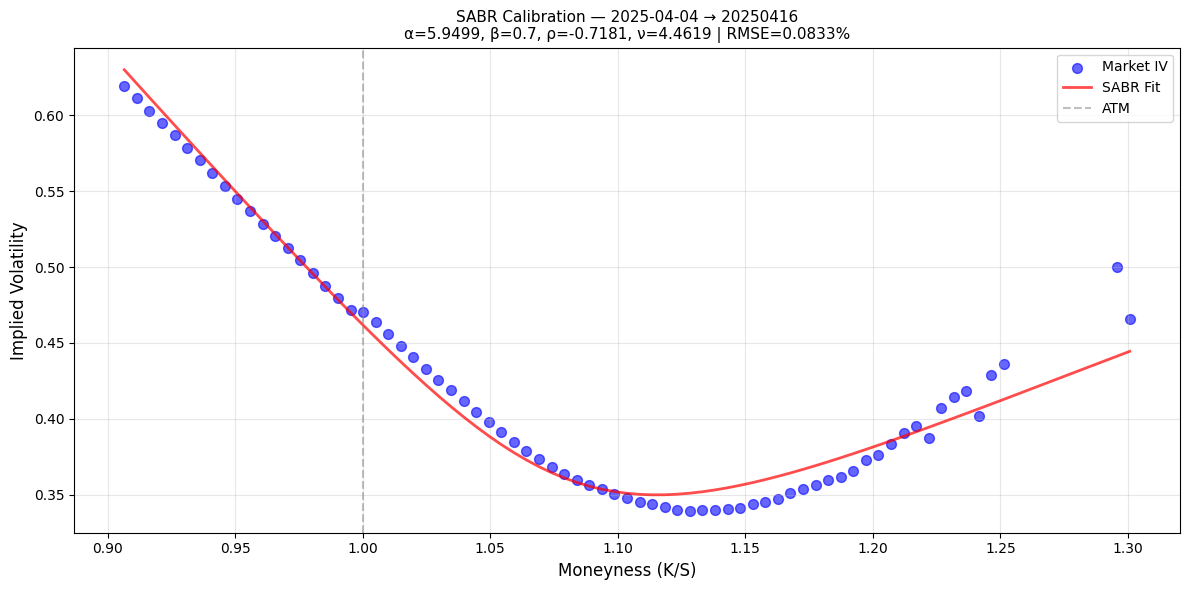

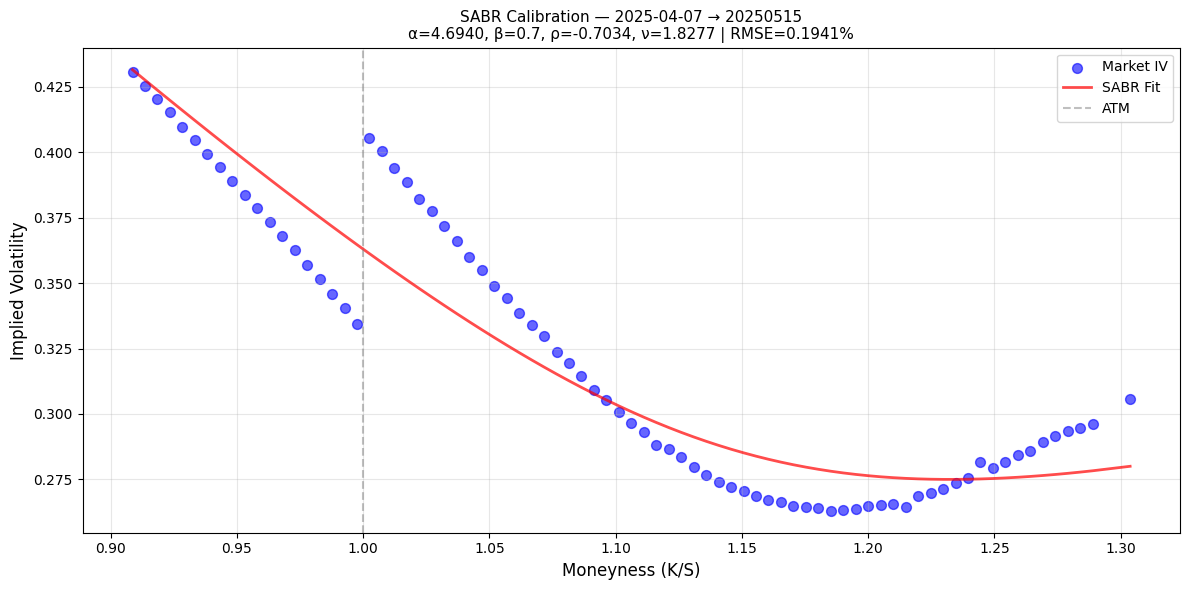


✓ Generated 5 sample plots


In [9]:
def plot_sabr_fit(result):
    """Plot SABR fit for a single date."""
    iv_df = result['iv_data']
    strikes = iv_df['strike'].values
    market_vols = iv_df['iv'].values

    # Generate SABR curve
    sabr_vols = np.array([
        SABR(result['forward'], K, result['T'],
             result['alpha'], result['beta'], result['rho'], result['nu'])
        for K in strikes
    ])

    # Calculate moneyness for better visualization
    moneyness = strikes / result['spot']

    plt.figure(figsize=(12, 6))
    
    plt.scatter(moneyness, market_vols, alpha=0.6, s=50, label='Market IV', color='blue')
    plt.plot(moneyness, sabr_vols, 'r-', linewidth=2, label='SABR Fit', alpha=0.7)
    plt.axvline(1.0, color='gray', linestyle='--', alpha=0.5, label='ATM')

    plt.xlabel('Moneyness (K/S)', fontsize=12)
    plt.ylabel('Implied Volatility', fontsize=12)
    plt.title(f"SABR Calibration — {result['date']} → {result['expiry']}\n"
              f"α={result['alpha']:.4f}, β={result['beta']:.1f}, ρ={result['rho']:.4f}, ν={result['nu']:.4f} | "
              f"RMSE={result['rmse']*100:.4f}%", fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()


# Plot first few dates
for i, result in enumerate(rth_results[:min(5, len(rth_results))]):
    fig = plot_sabr_fit(result)
    plt.savefig(f"sabr_fit_{result['date']}_{result['expiry']}.png", dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)

print(f"\n✓ Generated {min(5, len(rth_results))} sample plots")

### Known Limitation: ATM Dislocation

**Observation**: On some dates (notably April 3, April 7), there is a visible gap between market implied volatility and SABR fit at **moneyness = 1.0** (at-the-money).

#### Why This Happens

Three main causes:

1. **Put-Call Data Switch at Spot (Not Forward)**:
   - Code switches from puts to calls at `K ≤ S` (spot) instead of `K ≤ F` (forward)
   - Theoretically, ATM should be K = F (forward price), not K = S (spot)
   - This creates a discontinuity at moneyness = 1.0
   
   ```python
   # From calculate_implied_vols():
   if strike_val <= S:  # Uses spot S, not forward F
       mid_price = data['put_mid'][strike_key]
   else:
       mid_price = data['call_mid'][strike_key]
   ```

2. **SABR Enforces Smooth Smile**:
   - SABR model assumes a **smooth, continuous** volatility smile
   - Real market has kinks/jumps due to:
     - Dealer hedging flows
     - Pin risk near expiry
     - Different liquidity for puts vs calls
   
3. **Data Quality During Stress**:
   - April 3-7: Period of extreme volatility and uncertainty
   - Bid-ask spreads widened significantly
   - Stale quotes, rapid IV updates → noisier data
   - ATM options have highest trading volume → most sensitive to microstructure effects
 ATM dislocation is a known limitation of parametric models during market stress, but does not affect the robustness of our tail risk and volatility spike analyses.

## 9. Compare Specific Dates (April 1 vs April 8)


APRIL 1 vs APRIL 8 COMPARISON

April 1, 2025 (Pre-Event):
  Expiry: 20250416
  SABR: α=2.5158, ρ=-0.6053, ν=3.6601
  RMSE: 0.0806%

April 8, 2025 (Post-Event):
  Expiry: 20250515
  SABR: α=5.2040, ρ=-0.7929, ν=2.2917
  RMSE: 0.0357%


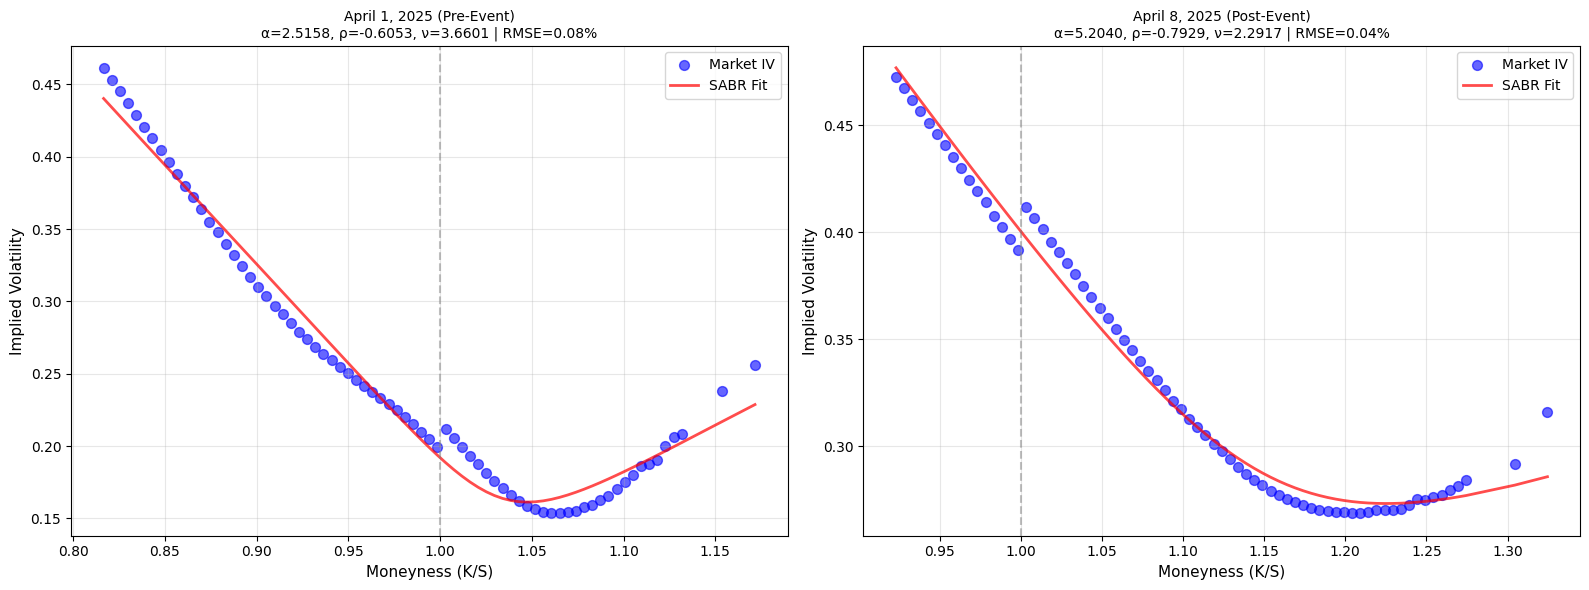

In [10]:
# Find April 1 and April 8 results
april1 = [r for r in rth_results if r['date'] == '2025-04-01']
april8 = [r for r in rth_results if r['date'] == '2025-04-08']

if april1 and april8:
    print("\n" + "="*80)
    print("APRIL 1 vs APRIL 8 COMPARISON")
    print("="*80)
    
    print("\nApril 1, 2025 (Pre-Event):")
    for r in april1:
        print(f"  Expiry: {r['expiry']}")
        print(f"  SABR: α={r['alpha']:.4f}, ρ={r['rho']:.4f}, ν={r['nu']:.4f}")
        print(f"  RMSE: {r['rmse']*100:.4f}%")
    
    print("\nApril 8, 2025 (Post-Event):")
    for r in april8:
        print(f"  Expiry: {r['expiry']}")
        print(f"  SABR: α={r['alpha']:.4f}, ρ={r['rho']:.4f}, ν={r['nu']:.4f}")
        print(f"  RMSE: {r['rmse']*100:.4f}%")
    
    # Side-by-side plot
    if len(april1) > 0 and len(april8) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        for idx, (result, ax, title) in enumerate([
            (april1[0], axes[0], "April 1, 2025 (Pre-Event)"),
            (april8[0], axes[1], "April 8, 2025 (Post-Event)")
        ]):
            iv_df = result['iv_data']
            strikes = iv_df['strike'].values
            market_vols = iv_df['iv'].values
            moneyness = strikes / result['spot']
            
            sabr_vols = np.array([
                SABR(result['forward'], K, result['T'],
                     result['alpha'], result['beta'], result['rho'], result['nu'])
                for K in strikes
            ])
            
            ax.scatter(moneyness, market_vols, alpha=0.6, s=50, label='Market IV', color='blue')
            ax.plot(moneyness, sabr_vols, 'r-', linewidth=2, label='SABR Fit', alpha=0.7)
            ax.axvline(1.0, color='gray', linestyle='--', alpha=0.5)
            
            ax.set_xlabel('Moneyness (K/S)', fontsize=11)
            ax.set_ylabel('Implied Volatility', fontsize=11)
            ax.set_title(f"{title}\nα={result['alpha']:.4f}, ρ={result['rho']:.4f}, ν={result['nu']:.4f} | RMSE={result['rmse']*100:.2f}%", fontsize=10)
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('april_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
else:
    print("\n⚠️ April 1 or April 8 data not found")